In [1]:
# - Check if the following properties chnage in each state
    # - Spike Rate
    # - Spike Regularity
    # - Intrinsic Time Constant
    # - Compare by neuron type

In [2]:
from drn_interactions.stats import cv_isi_burst, mannwhitneyu_plusplus
from drn_interactions.load import load_derived_generic, load_neurons_derived
from drn_interactions.spikes import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from drn_interactions.brain_state import get_state_piv
import numpy as np
import pandas as pd

def spikerate_change(df_piv):
    return (
        df_piv
        .reset_index()
        .melt(id_vars=["state", "bin"], var_name="neuron_id", value_name="counts")
        .groupby("neuron_id")
        .apply(lambda x: mannwhitneyu_plusplus(x.query("state == 'sw'")["counts"] ,x.query("state == 'act'")["counts"],
        names=["SW", "Act"]))
        .round(3)
    )

In [3]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons[["session_name"]].drop_duplicates().merge(eeg_states[["session_name"]].drop_duplicates())["session_name"].unique()

In [12]:
t_start=0
t_stop=1800
bin_width=1
spike_window = 120
session = sessions[14]

sh = SpikesHandler(
    "pre", 
    bin_width=bin_width, 
    session_names=[session],
     t_start=t_start, 
     t_stop=t_stop
    )
spikes = sh.binned_piv
eeg = eeg_states.query(f"session_name == '{session}'")
df = get_state_piv(spikes, eeg)

In [13]:
df_res = spikerate_change(df)
df_res.head()

,n_SW,n_Act,Mean_SW,Mean_Act,Diff,U,p
neuron_id,,,,,,,
2592,724.0,1075.0,13.007,5.918,-7.089,94943.0,0.000
2593,724.0,1075.0,14.978,12.493,-2.485,225839.0,0.000
2594,724.0,1075.0,1.707,1.601,-0.106,359771.5,0.003
2595,724.0,1075.0,0.326,1.779,1.453,245445.5,0.000
2596,724.0,1075.0,15.504,15.278,-0.226,370423.5,0.040


<AxesSubplot:>

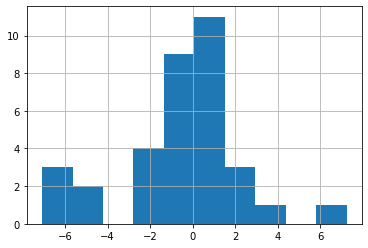

In [14]:
df_res["Diff"].hist()

In [6]:
# CV Change

from drn_interactions.brain_state import most_common_state_in_segment
from drn_interactions.transforms import segment_spikes

def cv_change_segments(df):
    return (
    df
    .groupby(["neuron_id", "segment", "state"])["spiketimes"]
    .apply(cv_isi_burst)
    .to_frame("cv")
    .reset_index()
    .groupby("neuron_id")
    .apply(lambda x: mannwhitneyu_plusplus(x.query("state == 'sw'")["cv"] ,x.query("state == 'act'")["cv"],
        names=["SW", "Act"]))
    .round(3)
    )


In [7]:
segments = np.arange(t_start, t_stop, spike_window)

# sh_surr = shuffle_spikes(sh)
spikes = sh.spikes

eeg = eeg_states.query(f"session_name == '{session}'")
spikes = segment_spikes(spikes, t_start=0, t_stop=1800, segment_length=120)
df = most_common_state_in_segment(spikes, eeg)
df_res = cv_change_segments(df)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

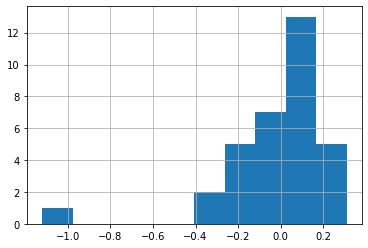

In [8]:
df_res["Diff"].hist()

In [ ]:
# Examples